In [ ]:
## This is a series of examples demonstrating the use of the icanswim/cosmosis repo 
## for data science and machine learning projects.
## This repo is intended to be used as the boiler plate for data science and machine learning projects.
## See the icanswim/qchem repo for a demonstration of the use of this (icanswim/cosmosis) repo.

In [1]:
from model import FFNet, tv_model
from learning import Learn, Selector, Metrics
from dataset import CDataset, SKDS, TVDS
from dataset import ImageDatasetStats, AsTensor, SqueezeN, DType, Pad, EmbedLookup

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [2]:
#example icanswim/cosmosis dataset (CDataset)
import numpy as np

class ExampleDataset(CDataset):
    
    embed_lookup = {'feature_4': {'a': 1,'b': 2,'c': 3,'d': 4, '0': 0},
                    'feature_3': {'z1': 1, 'y1': 2, 'x1': 3, '0': 0}}
    
    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([[.02,.03],[.04,.05]]),
                       'feature_3': np.asarray(['z1']),
                       'feature_4': np.asarray(['c','c','d']),
                       'feature_5': np.asarray([1.1])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([[.1,.2],[.3,.4]]),
                       'feature_3': np.asarray(['x1','z1','y1']),
                       'feature_4': np.asarray(['d','a','d']),
                       'feature_5': np.asarray([1.2])}}
        
        
        
        print(boom)
        return datadic
    
class ExampleTransform():
    def __init__(self, num):
        self.num = num
        
    def __call__(self, arr):
        return np.add(arr, self.num)

    
feature_3 = ExampleDataset.embed_lookup['feature_3']
ds_params = {'train_params': {'input_dict': {'model_input': {'X1': ['feature_1','feature_5'],
                                                             'X2': ['feature_5'],
                                                             'embed': ['feature_3']},
                                             'criterion_input': {'target': ['feature_2'],
                                                                 'embed': ['feature_4']}},
                              'transforms': {'feature_1': [ExampleTransform(10), Pad((5,))],
                                             'feature_2': [Pad((3,3))],
                                             'feature_3': [Pad((4,)), EmbedLookup(feature_3)]},
                              'boom': 'bang'}}
    
d = ExampleDataset(**ds_params['train_params'])
d[1]

bang
CDataset created...


{'model_input': {'X1': array([10.04,  0.  ,  0.  ,  0.  ,  0.  ,  1.1 ]),
  'X2': array([1.1]),
  'embed': [array([1]), array([0]), array([0]), array([0])]},
 'criterion_input': {'target': array([[0.02, 0.03, 0.  ],
         [0.04, 0.05, 0.  ],
         [0.  , 0.  , 0.  ]]),
  'embed': array(['c', 'c', 'd'], dtype='<U1')}}

In [3]:
#example cosmosis sklearn regression dataset wrapper (SKDS)
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

creating scikit learn make_regression dataset...
CDataset created...


{'model_input': {'features': array([ 0.3150642 , -0.42004487, -1.6219041 , -0.30792105,  1.2289815 ],
        dtype=float32)},
 'criterion_input': {'target': array([-118.76985], dtype=float32)}}

In [4]:
#example cosmosis sklearn classification dataset wrapper (SKDS)
ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'transforms': {'y': [],
                                             'X': [AsTensor()]},
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 1000,
                                            'n_features': 30,
                                            'n_informative': 20,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]['model_input']['X'].shape

creating scikit learn make_classification dataset...
CDataset created...


torch.Size([30])

In [5]:
#example cosmosis torchvision image dataset wrapper (TVDS)
ds_params={'dataset': 'MNIST',
           'input_dict': {'model_input': {'features': ['images'],},
                          'criterion_input': {'target': ['labels']}},
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

creating torch vision MNIST dataset...
CDataset created...


{'model_input': {'image': <PIL.Image.Image image mode=L size=224x224>},
 'criterion_input': {'target': 0}}

In [6]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and PIL stats
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

creating torch vision MNIST dataset...
CDataset created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


creating scikit learn make_regression dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.891468
epoch: 0, lr: 0.01
train loss: 589524.65625, val loss: 442803.42329545453
learning time: 0:00:06.880472
epoch: 10, lr: 0.005
train loss: 9793.765209056714, val loss: 13798.79727450284
learning time: 0:00:11.237139
epoch: 17, lr: 0.0025
train loss: 8926.891863787616, val loss: 8152.67919921875
early stopping!  learning rate is below the set minimum...
test loss: 7719.869451349432
learning time: 0:00:11.437252


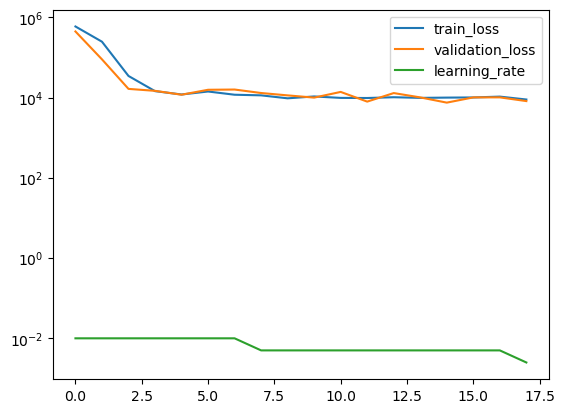

In [7]:
#example cosmosis sklearn regression dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples':20000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'min_lr': .005} #break if learning rate falls below                        
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5, 
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=40, gpu=True)

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:04.635358
epoch: 0, lr: 0.01
train loss: 0.01070437935818901, val loss: 0.010495089734785067
sklearn train metric: 0.5602406945000207, sklearn validation metric: 0.6091422840671369
learning time: 0:00:26.392417
epoch: 5, lr: 0.01
train loss: 0.009328155560016413, val loss: 0.009352281395123046
sklearn train metric: 0.7541498462084114, sklearn validation metric: 0.7506854169448557
learning time: 0:00:48.306361
epoch: 10, lr: 0.01
train loss: 0.008499608557644017, val loss: 0.008764686023131905
sklearn train metric: 0.8319865274719218, sklearn validation metric: 0.8052275009245538
learning time: 0:01:09.963588
epoch: 15, lr: 0.01
train loss: 0.00813599092879029, val loss: 0.008439131120904388
sklearn train metric: 0.8615276974201639, sklearn validation metric: 0.8327746927466098
test loss: 0.008340822170592017
learning time: 0:01:27.3

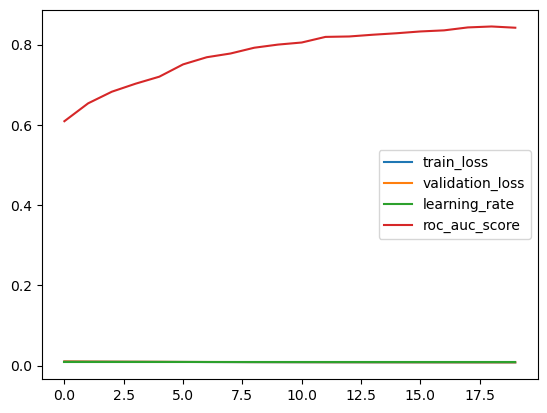

In [8]:
#example cosmosis sklearn classification dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4,
                'softmax': 'softmax',
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'transforms': {'y': [SqueezeN()],
                                             'X': []},
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 100000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_redundant': 5,
                                            'n_repeated': 5,
                                            'n_clusters_per_class': 5,
                                            'flip_y': 0.05,
                                            'class_sep': 0.05,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 20,
                  'log_plot': False,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=(300,256,.2), 
          squeeze_y_pred=False, batch_size=128, epochs=20, 
          save_model='demo_model')

In [9]:
#example inference with cosmosis sklearn classification dataset wrapper (SKDS) and custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     

metrics_params = {}
opt_params = {}
sample_params = {}
sched_params = {}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=None,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=128, epochs=1, load_model='demo_model.pth')

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
model loaded from pickle...
running model on gpu...
inference 2023-12-12 11:21:59.840604 complete and saved to csv...


creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
torchvision model resnet18 loaded...
running model on gpu...
learning time: 0:00:04.504343
epoch: 0, lr: 0.01
train loss: 2.285672691345215, val loss: 1.945598017784857
sklearn train metric: 0.6646808056932645, sklearn validation metric: 0.7665343208275932
learning time: 0:00:17.579005
epoch: 3, lr: 0.01
train loss: 1.6870794372558593, val loss: 1.6885986924171448
sklearn train metric: 0.824679850578606, sklearn validation metric: 0.8362548645560851
learning time: 0:00:30.852331
epoch: 6, lr: 0.01
train loss: 1.4387100753784179, val loss: 1.4182985280790636
sklearn train metric: 0.873228553291249, sklearn validation metric: 0.8826916192111197
learning time: 0:00:43.037799
epoch: 9, lr: 0.005
train loss: 1.1136001386642456, val loss: 1.3020542994622262
sklearn train metric: 0.9243737352434291

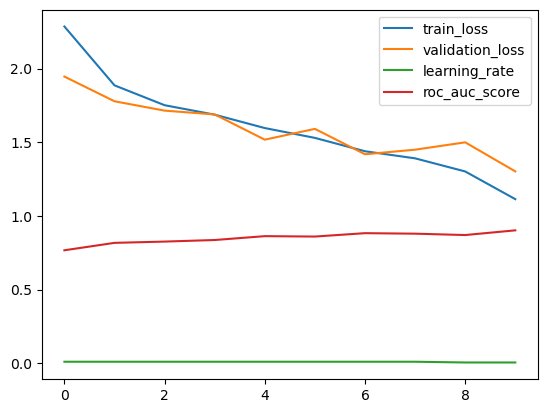

In [10]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params, 
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=16, epochs=10)

In [11]:
#example cosmosis torchvision dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 30, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=16, epochs=10)

creating torch vision CIFAR10 dataset...
CDataset created...
creating torch vision CIFAR10 dataset...
CDataset created...
torchvision model resnext50_32x4d loaded...
running model on gpu...


/home/fltr/cosmosis/learning.py:50: RuntimeWarning: overflow encountered in exp
  def softmax(x): return np.exp(x)/sum(np.exp(x))
/home/fltr/cosmosis/learning.py:50: RuntimeWarning: invalid value encountered in divide
  def softmax(x): return np.exp(x)/sum(np.exp(x))


ValueError: Input contains NaN.